In [1]:
import os
import sys
import time
import h5py
import pygrib
import numpy as np
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
from datetime import datetime, timedelta

sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def norm_precip(x):
    return np.log(x+1)

def norm_rh(x):
    return (x-50)/28/2

def norm_t(x):
    return (x-281)/10/2

def norm_u(x):
    return (x-3.5)/6.5/2

def norm_v(x):
    return (x)/6.5/2

def norm_pwat(x):
    return (x-20.5)/15/2

def norm_cape(x):
    return (x-200)/450/2

**Batch gen 2021**

In [4]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    #print(h5io.keys())
    lon_01 = h5io['lon_01'][...]
    lat_01 = h5io['lat_01'][...]
    elev_01 = h5io['elev_01'][...]
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...]

elev_01[elev_01<0] = 0
elev_01 = elev_01/2000 - 1

**generating batches**

In [5]:
x_mrms = 256
y_mrms = 576
x_gfs = 105
y_gfs = 242

In [6]:
# 0 MRMS HR precip
# 1 MRMS LR precip
# 2 GFS Precip
# 3 CAPE
# 4 PWAT
# 5 RH
# 6 U
# 7 V
# 7 T
# 8 elev

#T800 U800 V800, RH800, APCP, CAPE, PWAT

In [9]:
data = np.empty((1, x_mrms, y_mrms, 10))
gfs = np.empty((1, x_gfs, y_gfs, 8))

year = 2021
base = datetime(year, 1, 1)
date_list = [base + timedelta(days=h) for h in range(365)]
LEADs = [3, 6, 9, 12, 15, 18, 21, 24]
INIs = [0,] #[0, 6, 12, 18]

with h5py.File('/glade/campaign/cisl/aiml/ksha/GFS/MRMS_y{}.hdf'.format(year), 'r') as h5io:
    MRMS = h5io['MRMS'][...]

BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/'
batch_file_name = 'GFS_y{:04d}_ini{:02d}_lead{:02d}_dt{:04d}.npy'

name_gfs = '/glade/campaign/cisl/aiml/ksha/GFS/GFS_{}_ini{:02d}_f{:02d}.hdf'
name_apcp = '/glade/campaign/cisl/aiml/ksha/GFS/GFS_APCP_{}_ini{:02d}_f{:02d}.hdf'


for lead in LEADs:
    for ini in INIs:

        with h5py.File(name_gfs.format(year, ini, lead), 'r') as h5io:
            CAPE = h5io['CAPE'][...]
            PWAT = h5io['PWAT'][...]
            T800 = h5io['T800'][...]
            U800 = h5io['U800'][...]
            V800 = h5io['V800'][...]
            RH800 = h5io['RH800'][...]
        
        with h5py.File(name_apcp.format(year, ini, lead), 'r') as h5io:
            APCP = h5io['APCP'][...]

        for i_dt, dt in enumerate(date_list[:1]):
        
            N_hours = i_dt*24 + ini + lead
            
            MRMS_temp = MRMS[N_hours, ...] + MRMS[N_hours-1, ...] + MRMS[N_hours-2, ...]
            
            hr_to_lr = RegularGridInterpolator((lat_01[:, 0], lon_01[0, :]), MRMS_temp, 
                                               bounds_error=False, fill_value=None)
            MRMS_lr = hr_to_lr((lat_GFS, lon_GFS))
            
            gfs[..., 0] = MRMS_lr
            gfs[..., 1] = APCP[i_dt, ...]
            gfs[..., 2] = CAPE[i_dt, ...]
            gfs[..., 3] = PWAT[i_dt, ...]
            gfs[..., 4] = T800[i_dt, ...]
            gfs[..., 5] = U800[i_dt, ...]
            gfs[..., 6] = V800[i_dt, ...]
            gfs[..., 7] = RH800[i_dt, ...]
            
            data[..., 0] = MRMS_temp
            
            for i in range(8):
                lr_to_hr = RegularGridInterpolator((lat_GFS[:, 0], lon_GFS[0, :]), gfs[0, ..., i], 
                                                   bounds_error=False, fill_value=None)
                data[..., i+1] = lr_to_hr((lat_01, lon_01))
            
            temp = data[..., 1]
            temp[temp < 0] = 0
            data[..., 1] = temp
            
            data[..., 0] = norm_precip(data[..., 0])
            data[..., 1] = norm_precip(data[..., 1])
            data[..., 2] = norm_precip(data[..., 2])
            data[..., 3] = norm_cape(data[..., 3])
            data[..., 4] = norm_pwat(data[..., 4])
            data[..., 5] = norm_t(data[..., 5])
            data[..., 6] = norm_u(data[..., 6])
            data[..., 7] = norm_v(data[..., 7])
            data[..., 8] = norm_rh(data[..., 8])
            data[..., 9] = elev_01
            
            if np.sum(np.isnan(data)) == 0:
                name_ = BATCH_dir+batch_file_name.format(year, ini, lead, i_dt)
                print(name_)
                np.save(name_, data)

/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead03_dt0000.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead06_dt0000.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead09_dt0000.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead12_dt0000.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead15_dt0000.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead18_dt0000.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead21_dt0000.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead24_dt0000.npy


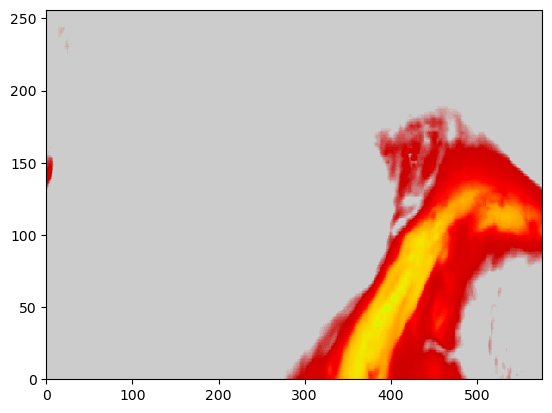

In [17]:
plt.pcolormesh(data[0, ..., 4], vmin=0, vmax=3, cmap=plt.cm.nipy_spectral_r)

In [147]:
np.max(elev_01)

3765.4207629569073

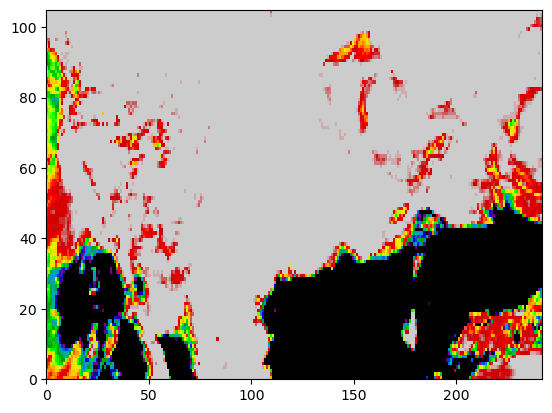

In [117]:
lead = LEADs[0]
ini = INIs[0]

with h5py.File(name_gfs.format(year, ini, lead), 'r') as h5io:
    CAPE = h5io['CAPE'][...]
    PWAT = h5io['PWAT'][...]
    T800 = h5io['T800'][...]
    U800 = h5io['U800'][...]
    V800 = h5io['V800'][...]
    RH800 = h5io['RH800'][...]

plt.pcolormesh(CAPE[-1, ...], vmin=0, vmax=100, cmap=plt.cm.nipy_spectral_r)

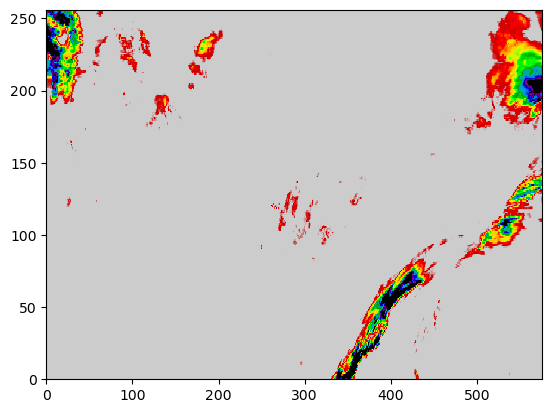

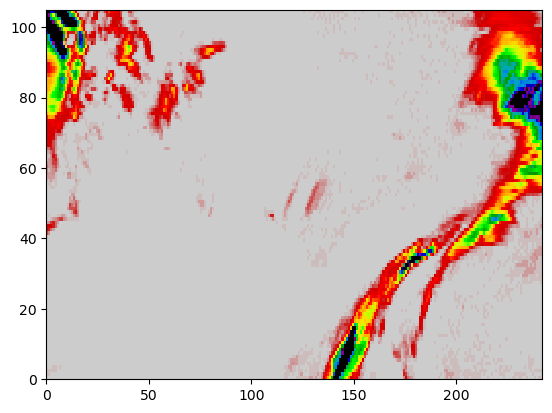

In [54]:
plt.pcolormesh(APCP_temp, vmin=0, vmax=10, cmap=plt.cm.nipy_spectral_r)

In [12]:
with pygrib.open(filename0) as grbio:
    MRMS = grbio[1].values
    
with pygrib.open(filename0) as grbio:
    MRMS += grbio[1].values
    
with pygrib.open(filename0) as grbio:
    MRMS += grbio[1].values
    
# flip --> lower latitude at the bottom
MRMS = np.flipud(MRMS)

In [13]:
with pygrib.open(filename_gfs) as grbio:
    T = grbio[314+1].values #
    U = grbio[319+1].values
    RH = grbio[315+1].values
    APCP = grbio[450+1].values
    CAPE = grbio[473+1].values
    PWAT = grbio[475+1].values

T_NA = T[:-360, 720:]
T_NA = np.flipud(np.concatenate((T_NA, T[:-360, 0][:, None]), axis=1))

U_NA = U[:-360, 720:]
U_NA = np.flipud(np.concatenate((U_NA, U[:-360, 0][:, None]), axis=1))

RH_NA = RH[:-360, 720:]
RH_NA = np.flipud(np.concatenate((RH_NA, RH[:-360, 0][:, None]), axis=1))

APCP_NA = APCP[:-360, 720:]
APCP_NA = np.flipud(np.concatenate((APCP_NA, APCP[:-360, 0][:, None]), axis=1))

CAPE_NA = CAPE[:-360, 720:]
CAPE_NA = np.flipud(np.concatenate((CAPE_NA, CAPE[:-360, 0][:, None]), axis=1))

PWAT_NA = PWAT[:-360, 720:]
PWAT_NA = np.flipud(np.concatenate((PWAT_NA, PWAT[:-360, 0][:, None]), axis=1))

In [ ]:
for i_mrms in range(0, x_mrms-size_mrms+gap, gap):
    for j_mrms in range(0, y_mrms-size_mrms+gap, gap):
        
        i0 = i_mrms; i1 = i0 + size_mrms
        j0 = j_mrms; j1 = j0 + size_mrms

        if (np.sum(RQI[i0:i1, j0:j1]) < 0.75) == 0:
        
            patch_ = MRMS[i0:i1, j0:j1]
            land_mask_ = land_mask_MRMS[i0:i1, j0:j1]

            r_rain = np.sum(patch_ > thres_dry)/N_grids
            
            flag_size = patch_.shape == (size_mrms, size_mrms)
            flag_rain_cover = r_rain >= thres_rain_cover
            flag_land_cover = (np.sum(land_mask_)/N_grids) >= thres_land_cover
            flag_extreme = np.logical_and(np.max(patch_) >= thres_extreme, r_rain >= thres_extreme_cover)

            flag_pass1 = np.logical_and(flag_rain_cover, flag_land_cover)
            flag_pass2 = np.logical_and(flag_extreme, flag_land_cover)
            flag_pass_final = np.logical_or(flag_pass1, flag_pass2)

            if flag_size and flag_pass_final:
                
                i_era = indx[i0:i1, j0:j1]
                j_era = indy[i0:i1, j0:j1]

                i_min = np.int(np.min(i_era))
                i_max = np.int(np.max(i_era))
                j_min = np.int(np.min(j_era))
                j_max = np.int(np.max(j_era))
                
                data_t = T_NA[i_min:i_max+1, j_min:j_max+1]
                data_u = U_NA[i_min:i_max+1, j_min:j_max+1]
                data_r = RH_NA[i_min:i_max+1, j_min:j_max+1]
                data_pwat = PWAT_NA[i_min:i_max+1, j_min:j_max+1]
                data_cape = CAPE_NA[i_min:i_max+1, j_min:j_max+1]
                data_apcp = APCP_NA[i_min:i_max+1, j_min:j_max+1]
                
                shape_lr = data_t.shape
                if shape_lr[0] == 6:
                    x_ = x_lr6
                else:
                    x_ = x_lr7
                
                if shape_lr[1] == 6:
                    y_ = x_lr6
                else:
                    y_ = x_lr7


                elev_ = elev_MRMS[i0:i1, j0:j1]
                data[0, ..., 8] = elev_
                
                interp_obj_t = interp2d(y_, x_, data_t, kind='linear')
                data[0, ..., 7] = interp_obj_t(x_hr128, x_hr128)

                interp_obj_u = interp2d(y_, x_, data_u, kind='linear')
                data[0, ..., 6] = interp_obj_u(x_hr128, x_hr128)

                interp_obj_r = interp2d(y_, x_, data_r, kind='linear')
                data[0, ..., 5] = interp_obj_r(x_hr128, x_hr128)

                interp_obj_pwat = interp2d(y_, x_, data_pwat, kind='linear')
                data[0, ..., 4] = interp_obj_pwat(x_hr128, x_hr128)

                interp_obj_cape = interp2d(y_, x_, data_cape, kind='linear')
                data[0, ..., 3] = interp_obj_cape(x_hr128, x_hr128)

                interp_obj_apcp = interp2d(y_, x_, data_apcp, kind='linear')
                data[0, ..., 2] = interp_obj_apcp(x_hr128, x_hr128)

                data[0, ..., 0] = patch_
                
                hr_to_lr = interp2d(x_hr, x_hr, data[0, ..., 0], kind='linear')
                data_lr = hr_to_lr(y_, x_)
                lr_to_hr = interp2d(y_, x_, data_lr, kind='linear')
                data_hr = lr_to_hr(x_hr, x_hr)

                data[0, ..., 1] = data_hr
                
                data[0, ..., 0] = norm_precip(data[0, ..., 0])
                data[0, ..., 1] = norm_precip(data[0, ..., 1])
                data[0, ..., 2] = norm_precip(data[0, ..., 2])
                data[0, ..., 3] = norm_cape(data[0, ..., 3])
                data[0, ..., 4] = norm_pwat(data[0, ..., 4])
                data[0, ..., 5] = norm_rh(data[0, ..., 5])
                data[0, ..., 6] = norm_u(data[0, ..., 6])
                data[0, ..., 7] = norm_t(data[0, ..., 7])
 
                # flag_save = True
                # for i_test in range(5):
                #     temp = np.abs(data[0, ..., 3+i_test])
                #     if np.sum(temp > 1e-6) == 0:
                #         flag_save = False
                        
                # if flag_save:
                name_ = BATCH_dir+batch_file_name.format(year, lead, i_dt, i_mrms, j_mrms)
                print(name_)
                np.save(name_, data)
                eawrareeeg

/glade/campaign/cisl/aiml/ksha/BATCH_GFS/GFS_y2021_lead03_dt0000_i0704_j3712.npy


In [35]:
data = np.load('/glade/campaign/cisl/aiml/ksha/BATCH_GFS/GFS_y2021_lead03_dt0000_i1024_j3584.npy')

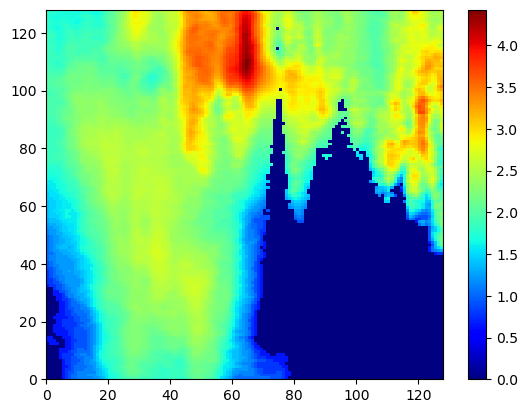

In [42]:
plt.pcolormesh(data[0, ..., 0], cmap=plt.cm.jet)
plt.colorbar()

In [ ]:
for lead in LEADs:
    # Main section
    for i_dt, dt in enumerate(date_list[:1]):
    
        filename_gfs = datetime.strftime(dt, 
        '/glade/campaign/collections/rda/data/ds084.1/%Y/%Y%m%d/gfs.0p25.%Y%m%d%H.f{:03d}.grib2'.format(lead))
        
        dt0 = dt + timedelta(hours=lead-2)
        dt1 = dt + timedelta(hours=lead-1)
        dt2 = dt + timedelta(hours=lead)
    
        dt_str0 = datetime.strftime(dt0, '%Y%m%d-%H%M%S')
        dt_str1 = datetime.strftime(dt1, '%Y%m%d-%H%M%S')
        dt_str2 = datetime.strftime(dt2, '%Y%m%d-%H%M%S')
        
        name0 = 'MRMS_MultiSensor_QPE_01H_Pass2_00.00_{}.grib2'.format(dt_str0)
        name1 = 'MRMS_MultiSensor_QPE_01H_Pass2_00.00_{}.grib2'.format(dt_str1)
        name2 = 'MRMS_MultiSensor_QPE_01H_Pass2_00.00_{}.grib2'.format(dt_str2)
        
        filename0 = MRMS_dir + name0
        filename1 = MRMS_dir + name1
        filename2 = MRMS_dir + name2
    
        flag_mrms0 = os.path.isfile(filename0)
        flag_mrms1 = os.path.isfile(filename1)
        flag_mrms2 = os.path.isfile(filename2)
        flag_gfs = os.path.isfile(filename_gfs)
        
        if np.logical_and(np.logical_and(np.logical_and(flag_mrms0, flag_mrms1), flag_mrms2), flag_gfs):
            with pygrib.open(filename0) as grbio:
                MRMS = grbio[1].values
                
            with pygrib.open(filename0) as grbio:
                MRMS += grbio[1].values
                
            with pygrib.open(filename0) as grbio:
                MRMS += grbio[1].values
                
            # flip --> lower latitude at the bottom
            MRMS = np.flipud(MRMS)
            
            print(filename_gfs)
            
            with pygrib.open(filename_gfs) as grbio:
                T = grbio[314+1].values #
                U = grbio[319+1].values
                RH = grbio[315+1].values
                APCP = grbio[450+1].values
                CAPE = grbio[473+1].values
                PWAT = grbio[475+1].values
            
            T_NA = T[:-360, 720:]
            T_NA = np.flipud(np.concatenate((T_NA, T[:-360, 0][:, None]), axis=1))
            
            U_NA = U[:-360, 720:]
            U_NA = np.flipud(np.concatenate((U_NA, U[:-360, 0][:, None]), axis=1))
            
            RH_NA = RH[:-360, 720:]
            RH_NA = np.flipud(np.concatenate((RH_NA, RH[:-360, 0][:, None]), axis=1))
            
            APCP_NA = APCP[:-360, 720:]
            APCP_NA = np.flipud(np.concatenate((APCP_NA, APCP[:-360, 0][:, None]), axis=1))
            
            CAPE_NA = CAPE[:-360, 720:]
            CAPE_NA = np.flipud(np.concatenate((CAPE_NA, CAPE[:-360, 0][:, None]), axis=1))
            
            PWAT_NA = PWAT[:-360, 720:]
            PWAT_NA = np.flipud(np.concatenate((PWAT_NA, PWAT[:-360, 0][:, None]), axis=1))
            
            for i_mrms in range(0, x_mrms-size_mrms+gap, gap):
                for j_mrms in range(0, y_mrms-size_mrms+gap, gap):
                    
                    i0 = i_mrms; i1 = i0 + size_mrms
                    j0 = j_mrms; j1 = j0 + size_mrms
    
                    if (np.sum(RQI[i0:i1, j0:j1]) < 0.75) == 0:
                    
                        patch_ = MRMS[i0:i1, j0:j1]
                        land_mask_ = land_mask_MRMS[i0:i1, j0:j1]
    
                        r_rain = np.sum(patch_ > thres_dry)/N_grids
                        
                        flag_size = patch_.shape == (size_mrms, size_mrms)
                        flag_rain_cover = r_rain >= thres_rain_cover
                        flag_land_cover = (np.sum(land_mask_)/N_grids) >= thres_land_cover
                        flag_extreme = np.logical_and(np.max(patch_) >= thres_extreme, r_rain >= thres_extreme_cover)
        
                        flag_pass1 = np.logical_and(flag_rain_cover, flag_land_cover)
                        flag_pass2 = np.logical_and(flag_extreme, flag_land_cover)
                        flag_pass_final = np.logical_or(flag_pass1, flag_pass2)
        
                        if flag_size and flag_pass_final:
                            
                            i_era = indx[i0:i1, j0:j1]
                            j_era = indy[i0:i1, j0:j1]
    
                            i_min = np.int(np.min(i_era))
                            i_max = np.int(np.max(i_era))
                            j_min = np.int(np.min(j_era))
                            j_max = np.int(np.max(j_era))
                            
                            data_t = T_NA[i_min:i_max+1, j_min:j_max+1]
                            data_u = U_NA[i_min:i_max+1, j_min:j_max+1]
                            data_r = RH_NA[i_min:i_max+1, j_min:j_max+1]
                            data_pwat = PWAT_NA[i_min:i_max+1, j_min:j_max+1]
                            data_cape = CAPE_NA[i_min:i_max+1, j_min:j_max+1]
                            data_apcp = APCP_NA[i_min:i_max+1, j_min:j_max+1]
                            
                            shape_lr = data_t.shape
                            if shape_lr[0] == 6:
                                x_ = x_lr6
                            else:
                                x_ = x_lr7
                            
                            if shape_lr[1] == 6:
                                y_ = x_lr6
                            else:
                                y_ = x_lr7
    
    
                            elev_ = elev_MRMS[i0:i1, j0:j1]
                            data[0, ..., 8] = elev_
                            
                            interp_obj_t = interp2d(y_, x_, data_t, kind='linear')
                            data[0, ..., 7] = interp_obj_t(x_hr128, x_hr128)
    
                            interp_obj_u = interp2d(y_, x_, data_u, kind='linear')
                            data[0, ..., 6] = interp_obj_u(x_hr128, x_hr128)
    
                            interp_obj_r = interp2d(y_, x_, data_r, kind='linear')
                            data[0, ..., 5] = interp_obj_r(x_hr128, x_hr128)
    
                            interp_obj_pwat = interp2d(y_, x_, data_pwat, kind='linear')
                            data[0, ..., 4] = interp_obj_pwat(x_hr128, x_hr128)
    
                            interp_obj_cape = interp2d(y_, x_, data_cape, kind='linear')
                            data[0, ..., 3] = interp_obj_cape(x_hr128, x_hr128)
    
                            interp_obj_apcp = interp2d(y_, x_, data_apcp, kind='linear')
                            data[0, ..., 2] = interp_obj_apcp(x_hr128, x_hr128)
    
                            data[0, ..., 0] = patch_
                            
                            hr_to_lr = interp2d(x_hr, x_hr, data[0, ..., 0], kind='linear')
                            data_lr = hr_to_lr(y_, x_)
                            lr_to_hr = interp2d(y_, x_, data_lr, kind='linear')
                            data_hr = lr_to_hr(x_hr, x_hr)
    
                            data[0, ..., 1] = data_hr
                            
                            data[0, ..., 0] = norm_precip(data[0, ..., 0])
                            data[0, ..., 1] = norm_precip(data[0, ..., 1])
                            data[0, ..., 2] = norm_precip(data[0, ..., 2])
                            data[0, ..., 3] = norm_cape(data[0, ..., 3])
                            data[0, ..., 4] = norm_pwat(data[0, ..., 4])
                            data[0, ..., 5] = norm_rh(data[0, ..., 5])
                            data[0, ..., 6] = norm_u(data[0, ..., 6])
                            data[0, ..., 7] = norm_t(data[0, ..., 7])
    
                            flag_save = True
                            for i_test in range(5):
                                temp = np.abs(data[0, ..., 3+i_test])
                                if np.sum(temp > 1e-6) == 0:
                                    flag_save = False
                                    
                            if flag_save:
                                name_ = BATCH_dir+batch_file_name.format(year, lead, i_dt, i_mrms, j_mrms)
                                print(name_)
                                np.save(name_, data)

/glade/campaign/collections/rda/data/ds084.1/2021/20210101/gfs.0p25.2021010100.f003.grib2
/glade/campaign/cisl/aiml/ksha/BATCH_GFS/GFS_y2021_lead03_dt0000_i0704_j3712.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS/GFS_y2021_lead03_dt0000_i0704_j3776.npy


In [45]:
data = np.load('/glade/campaign/cisl/aiml/ksha/BATCH_GFS/GFS_y2021_lead03_dt0000_i0664_j3704.npy')

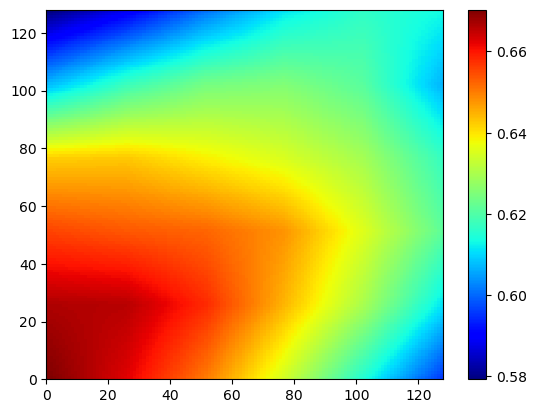

In [52]:
plt.pcolormesh(data[0, ..., 6], cmap=plt.cm.jet)
plt.colorbar()